In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os
os.environ['REQUESTS_CA_BUNDLE'] = ''

In [4]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#  Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head 
class_names = ['circlar alopecia','flees','healthy','runglong','skin lesions']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [5]:
from torchinfo import summary


summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 

        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:

train_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train'
test_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/test'

In [7]:

pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):


  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)


  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:

train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [11]:
from going_modular.going_modular import engine


optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [10:31<3:20:00, 631.59s/it]

Epoch: 1 | train_loss: 0.4270 | train_acc: 0.8634 | test_loss: 0.4048 | test_acc: 0.8698


 10%|█         | 2/20 [24:19<3:44:10, 747.25s/it]

Epoch: 2 | train_loss: 0.1548 | train_acc: 0.9641 | test_loss: 0.2967 | test_acc: 0.8958


 15%|█▌        | 3/20 [39:27<3:52:25, 820.32s/it]

Epoch: 3 | train_loss: 0.1017 | train_acc: 0.9788 | test_loss: 0.2447 | test_acc: 0.9193


 20%|██        | 4/20 [53:37<3:41:55, 832.20s/it]

Epoch: 4 | train_loss: 0.0750 | train_acc: 0.9860 | test_loss: 0.2182 | test_acc: 0.9323


 25%|██▌       | 5/20 [1:09:34<3:39:17, 877.14s/it]

Epoch: 5 | train_loss: 0.0587 | train_acc: 0.9903 | test_loss: 0.2000 | test_acc: 0.9375


 30%|███       | 6/20 [1:23:16<3:20:19, 858.57s/it]

Epoch: 6 | train_loss: 0.0478 | train_acc: 0.9926 | test_loss: 0.1918 | test_acc: 0.9505


 35%|███▌      | 7/20 [1:36:44<3:02:27, 842.09s/it]

Epoch: 7 | train_loss: 0.0400 | train_acc: 0.9946 | test_loss: 0.1904 | test_acc: 0.9453


 40%|████      | 8/20 [1:51:04<2:49:32, 847.70s/it]

Epoch: 8 | train_loss: 0.0335 | train_acc: 0.9965 | test_loss: 0.1840 | test_acc: 0.9453


 45%|████▌     | 9/20 [2:06:11<2:38:46, 866.09s/it]

Epoch: 9 | train_loss: 0.0295 | train_acc: 0.9956 | test_loss: 0.1825 | test_acc: 0.9479


 50%|█████     | 10/20 [2:21:55<2:28:22, 890.22s/it]

Epoch: 10 | train_loss: 0.0248 | train_acc: 0.9979 | test_loss: 0.1800 | test_acc: 0.9531


 55%|█████▌    | 11/20 [2:40:20<2:23:24, 956.05s/it]

Epoch: 11 | train_loss: 0.0220 | train_acc: 0.9983 | test_loss: 0.1690 | test_acc: 0.9505


 60%|██████    | 12/20 [2:58:32<2:12:58, 997.29s/it]

Epoch: 12 | train_loss: 0.0192 | train_acc: 0.9983 | test_loss: 0.1745 | test_acc: 0.9479


 65%|██████▌   | 13/20 [3:15:43<1:57:32, 1007.45s/it]

Epoch: 13 | train_loss: 0.0172 | train_acc: 0.9986 | test_loss: 0.1712 | test_acc: 0.9531


 70%|███████   | 14/20 [3:32:06<1:40:01, 1000.28s/it]

Epoch: 14 | train_loss: 0.0153 | train_acc: 0.9990 | test_loss: 0.1723 | test_acc: 0.9505


 75%|███████▌  | 15/20 [3:47:52<1:21:59, 983.92s/it] 

Epoch: 15 | train_loss: 0.0135 | train_acc: 0.9996 | test_loss: 0.1724 | test_acc: 0.9531


 80%|████████  | 16/20 [4:04:26<1:05:47, 986.81s/it]

Epoch: 16 | train_loss: 0.0122 | train_acc: 0.9990 | test_loss: 0.1797 | test_acc: 0.9505


 85%|████████▌ | 17/20 [4:18:14<46:57, 939.21s/it]  

Epoch: 17 | train_loss: 0.0110 | train_acc: 0.9994 | test_loss: 0.1744 | test_acc: 0.9531


 90%|█████████ | 18/20 [4:32:06<30:13, 906.95s/it]

Epoch: 18 | train_loss: 0.0102 | train_acc: 0.9996 | test_loss: 0.1784 | test_acc: 0.9479


 95%|█████████▌| 19/20 [4:45:50<14:42, 882.05s/it]

Epoch: 19 | train_loss: 0.0092 | train_acc: 0.9994 | test_loss: 0.1721 | test_acc: 0.9531


100%|██████████| 20/20 [5:00:07<00:00, 900.37s/it]

Epoch: 20 | train_loss: 0.0084 | train_acc: 0.9996 | test_loss: 0.1795 | test_acc: 0.9505


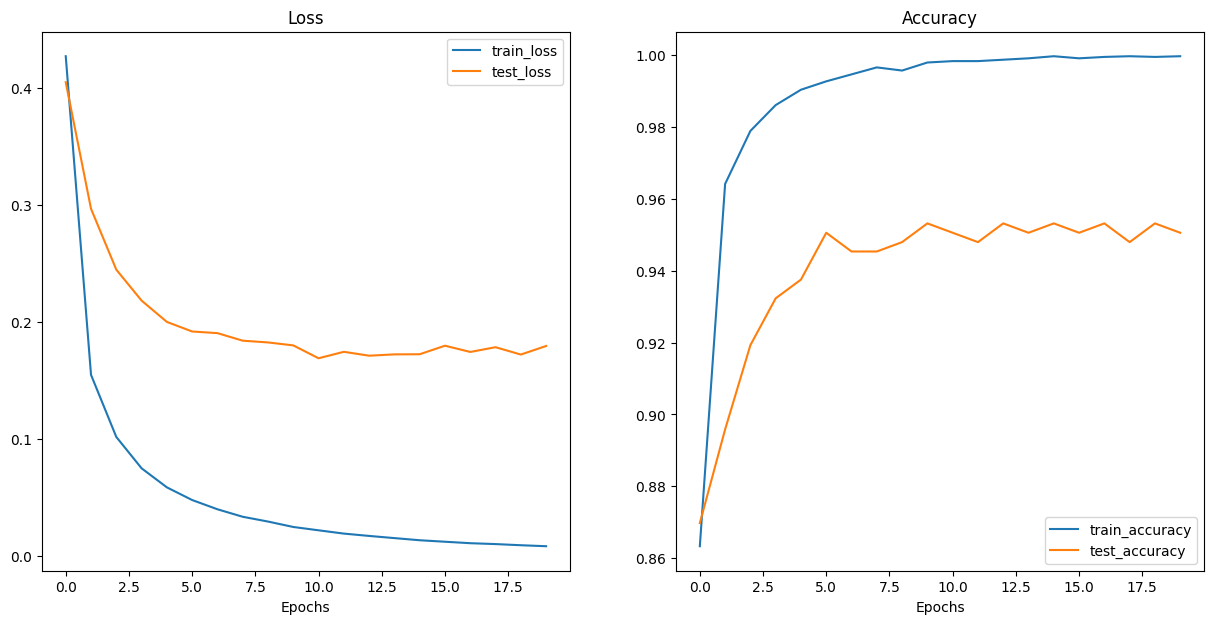

In [12]:

from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

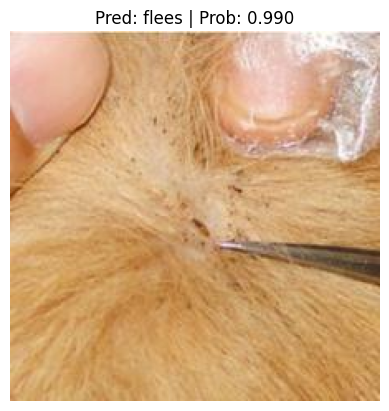

In [13]:
import requests


from going_modular.going_modular.predictions import pred_and_plot_image


custom_image_path = "/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train/flees/An-adult-flea-and-flea-feces-on-the-surface-of-a-dog-skin_Q320_jpg.rf.d843b7a4063ce3f8edbffd42d244bb5e.jpg"


pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

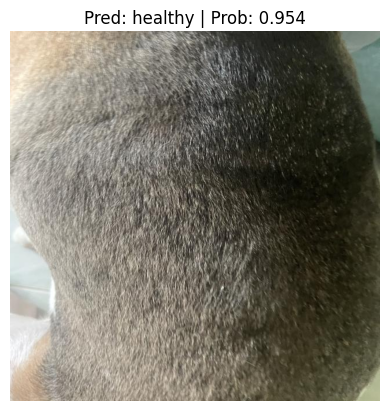

In [23]:

from going_modular.going_modular.predictions import pred_and_plot_image


custom_image_path = "/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train/healthy/IMG_3937_png.rf.736542c9bf90edea159662d10833a0d4.jpg"


pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [15]:
# Save the model
model_save_path = "pretrained_vit_skin_final.pth"
torch.save(pretrained_vit, model_save_path)

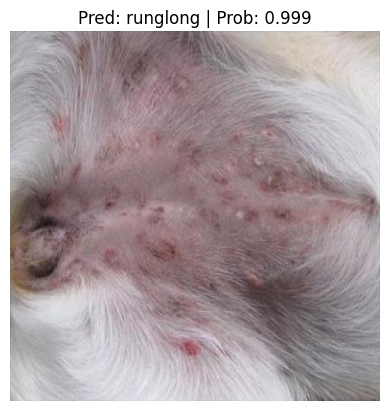

In [25]:
import requests
import torch
from going_modular.going_modular.predictions import pred_and_plot_image

class_names = ['circlar alopecia','flees','healthy','runglong','skin lesions']


saved_model_path = "/Users/chamidiperera/Documents/FYP Codes/savedModels/skin/pretrained_vit_skin_final.pth"
pretrained_vit = torch.load(saved_model_path)


custom_image_path = "/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train/runglong/1706_jpg.rf.891984d2d679248ce5ae28e29fa01dbd.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
